In [1]:
from torch.utils.data import random_split, DataLoader, Dataset
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, Precision, Recall
from IPython.display import clear_output
import pandas as pd
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from ignite.engine import Events

In [2]:
BATCH_SIZE = 128
learning_rate = 1e-3
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
train_df, test_df = pd.read_csv('digit-recognizer/train.csv'), pd.read_csv('digit-recognizer/test.csv')
train_df.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dataset Preparation

In [4]:
from PIL import Image
from torchvision import transforms
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self, data_, transform):
        self.data = data_
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if 'label' in self.data.columns:
            label = sample['label']
            pixels = np.array(sample[1:].values).astype(np.uint8).reshape(28, 28)
        else:
            label = ''
            pixels = np.array(sample.values).astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(pixels)
        if self.transform:
            image = self.transform(image)
        return image, label
            

    def show_images(self, idx):
        img = self.data.iloc[idx]
        if 'label' in self.data.columns:
            pixels = np.array(img[1:].values).astype(np.uint8).reshape(28, 28) 
        else:
            pixels = np.array(img.values).astype(np.uint8).reshape(28, 28) 
        image = Image.fromarray(pixels)
        return image

    def __len__(self):
        return len(self.data)

In [5]:
transform_ = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
data = Data(data_ = train_df, transform=transform_)
test = Data(data_ = test_df, transform=transform_)

In [6]:
def show_transformed(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        _, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        # call a function
        plt.imshow(dataset.show_images(sample_idx))
    plt.show()

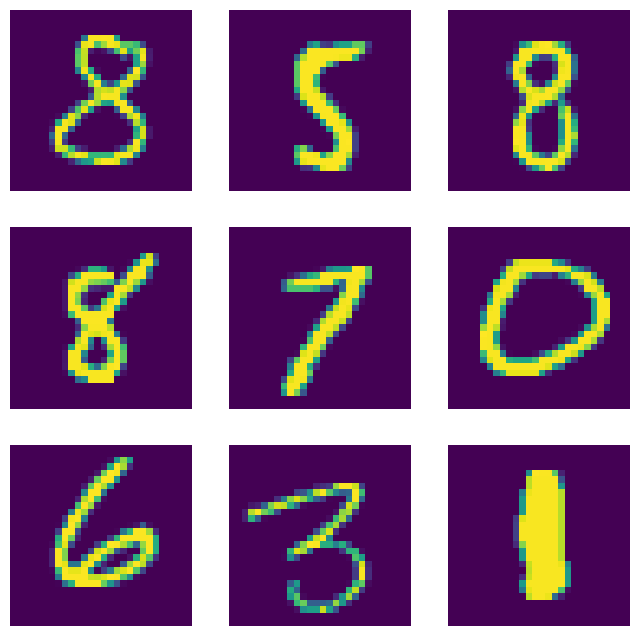

In [7]:
show_transformed(dataset = test)

# Train Validation Split

In [8]:
dataset_length = len(data)
train_size = int(0.95 * dataset_length)
test_size = dataset_length - train_size
train_df, validation_df = random_split(data, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_df, batch_size=BATCH_SIZE)
validation_loader = DataLoader(validation_df, batch_size=BATCH_SIZE)

# The first model type: fully connected network

In [10]:
class Linear_Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.ln1 = nn.Linear(in_features=28*28, out_features=256)
        self.relu1 = nn.ReLU(inplace=True)
        self.ln2 = nn.Linear(in_features=256, out_features=512)
        self.relu2 = nn.ReLU(inplace=True)
        self.ln3 = nn.Linear(in_features=512, out_features=10)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.ln1(x))  
        x = self.relu2(self.ln2(x))
        x = self.softmax(self.ln3(x))
        return x

In [11]:
linear_model = Linear_Model().to(device)
image = torch.rand((1, 1, 28, 28)).to(device)
output = linear_model(image)
print(summary(linear_model,input_size=(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
           Softmax-7                   [-1, 10]               0
Total params: 337,674
Trainable params: 337,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.29
Estimated Total Size (MB): 1.31
----------------------------------------------------------------
None


/Users/boris/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# Traininig and evaluation 


In [12]:
optimizer = torch.optim.Adam(linear_model.parameters(), lr=learning_rate)
loss_type = torch.nn.CrossEntropyLoss()
epochs = 10
train_loss, validation_loss = [], []
train_accuracy, validation_accuracy = [], []

In [31]:
def training_and_evaluating(model, optimizer, loss_type, device):
    for epoch in range(1, epochs + 1):

        def draw_plots(train_accuracy, validation_accuracy, train_loss, validation_loss):
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            axes[0][0].plot(train_accuracy, color = 'blue', linestyle = '--', label = 'Train Accuracy')
            axes[0][0].set_ylabel('Accuracy')
            axes[0][0].set_xlabel('Epochs')
            axes[0][0].legend()

            axes[0][1].plot(validation_accuracy, color = 'red', linestyle = '--', label = 'Validation Accuracy')
            axes[0][1].set_ylabel('Accuracy')
            axes[0][1].set_xlabel('Epochs')
            axes[0][1].legend()

            axes[1][0].plot(train_loss, color = 'blue', linestyle = '--', label = 'Train Loss')
            axes[1][0].set_ylabel('Loss')
            axes[1][0].set_xlabel('Epochs')
            axes[1][0].legend()

            axes[1][1].plot(validation_loss, color = 'red', linestyle = '--', label = 'Validation Loss')
            axes[1][1].set_ylabel('Loss')
            axes[1][1].set_xlabel('Epochs')
            axes[1][1].legend()

        def print_epoch_results(engine, type=''):
            result = "\t".join([f"{i}:{j}" for i, j in engine.state.metrics.items()])
            print(f"Results after {type} epoch:", result)

        def one_epoch(engine):
            # evaluate on trainig and validation datasets
            train_eval.run(train_loader)
            valid_eval.run(validation_loader)

            # extract metrics from engine
            validation_results = valid_eval.state.metrics
            train_results = train_eval.state.metrics

            # metrics are stored into dictionary
            train_accuracy.append(round(train_results['Accuracy'], 4))
            validation_accuracy.append(round(validation_results['Accuracy'], 4))
            train_loss.append(train_results['Loss'])
            validation_loss.append(validation_results['Loss'])

            # dynamically sketch plots
            # draw_plots(train_accuracy, validation_accuracy,
            #            train_loss, validation_loss)

        # clear the grid before new epoch 
        def clear_output_handler(engine):
            clear_output(wait=True)

        trainer = create_supervised_trainer(model, optimizer, loss_type, device)

        # choose metrics to show
        metrics_for_task = {
            "Accuracy": Accuracy(),
            # "Precision": Precision().mean(),
            # "Recall": Recall().mean(),
            "Loss": Loss(loss_type)
        }

        train_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)
        valid_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)

        # start new epoch
        trainer.add_event_handler(Events.EPOCH_COMPLETED, one_epoch)

        # draw graphs during the epoch
        # trainer.add_event_handler(Events.ITERATION_COMPLETED(every=25), draw_plots(train_accuracy,
        #                                                                            validation_accuracy,
        #                                                                            train_loss,
        #                                                                            validation_loss))

        # print train and validation results
        train_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type="Train")
        valid_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type="Validation")

        print(f'Epoch {epoch} from {epochs}')
        # train model
        trainer.run(train_loader)

Results after Train epoch: Accuracy:0.9935338345864662	Loss:1.467585467575188
Results after Validation epoch: Accuracy:0.9738095238095238	Loss:1.486875


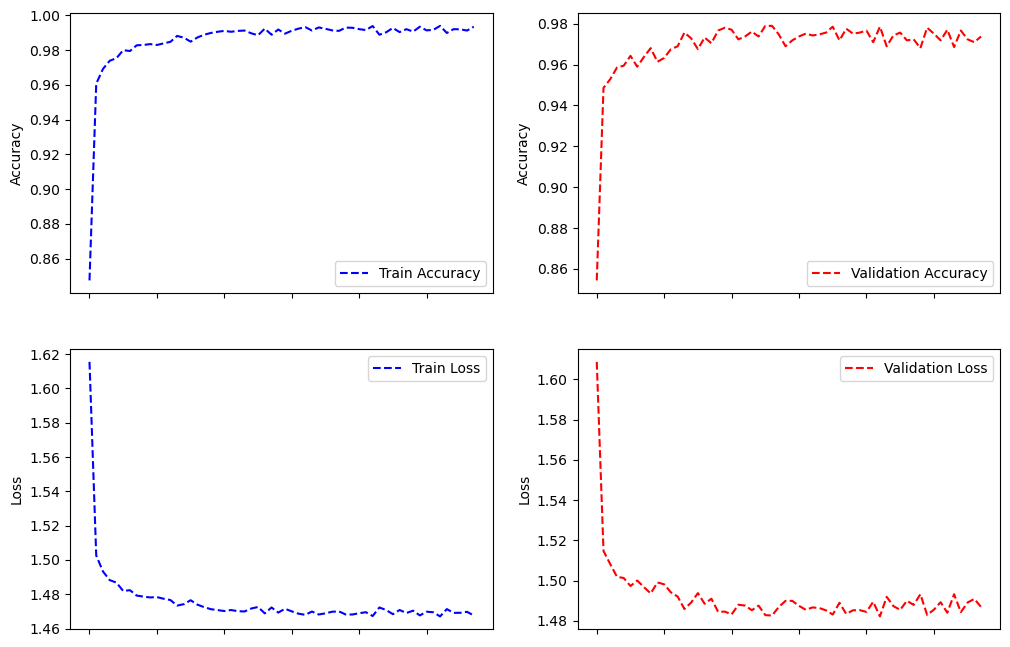

Epoch 7 from 10


Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [32]:
training_and_evaluating(model = linear_model, optimizer = optimizer, loss_type=loss_type, device = device)